# Preliminaries

In [1]:
# Required standard libraries
import pandas as pd
import json
import urllib
import requests
import os
import re
import numpy as np
import bs4 as bs
import selenium
import html5lib
#import nltk
import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from matplotlib import pyplot as plt

# Extractors 
import extract

# Cleansers (cluster specific)
import cleanse

# Normalizer (generalised across all clusters)
from normalize import scaler

# Utils
from utils import utils

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Define file paths

In [2]:
# Define the export path for all data exports
from pathlib import Path

# Current working directory
cwd = Path('.')

# Folder with data-in artifacts, quired to run this script
data_in = cwd / 'data_in'

# Folder containing data, which has been extracted manually, but entered by a machine
data_sources_raw_manual_machine = cwd / 'data_in' / 'data_raw_manually_extracted' / 'machine_entered'
data_sources_raw_manual_machine.mkdir(parents=True, exist_ok=True)

# Folder containing data, which has been extracted manually, and entered by a human
data_sources_raw_manual_human = cwd / 'data_in' / 'data_raw_manually_extracted' / 'human_entered'
data_sources_raw_manual_human.mkdir(parents=True, exist_ok=True)

# Folder containing manually extracted raw data, ready to be put in the loop
data_sources_staged_raw = cwd / 'data_out' / 'data_staged_raw'
data_sources_staged_raw.mkdir(parents=True, exist_ok=True)

# Folder to export raw data
data_sources_raw = cwd / 'data_out' / 'data_raw'
data_sources_raw.mkdir(parents=True, exist_ok=True)

# Folder to export cleansed data
data_sources_cleansed = cwd / 'data_out' / 'data_cleansed'
data_sources_cleansed.mkdir(parents=True, exist_ok=True)

# Folder to export normalized data
data_sources_normalized = cwd / 'data_out' / 'data_normalized'
data_sources_normalized.mkdir(parents=True, exist_ok=True)

# Folder to export validation results
validation_and_analysis = cwd / 'data_out' / 'data_validation'
validation_and_analysis.mkdir(parents=True, exist_ok=True)

## Load country list and mapping dictionary

In [3]:
# Load the list of countries which contains all different variations of country names 
country_full_list = pd.read_excel(
    data_in / 'all_countrynames_list.xlsx',
    keep_default_na = False).drop_duplicates()

# Create a version of the list with unique ISO2 and ISO3 codes
country_iso_list = country_full_list.drop_duplicates(subset = 'COUNTRY_ISO_2')

# Country CRBA list, this is the list of the countries that should be in the final CRBA indicator list
country_crba_list = pd.read_excel(
    data_in / 'crba_country_list.xlsx',
    header = None,
    usecols = [0, 1], 
    names = ['COUNTRY_ISO_3', 'COUNTRY_NAME']).merge(
        right = country_iso_list[['COUNTRY_ISO_2', 'COUNTRY_ISO_3']],
        how = 'left',
        on='COUNTRY_ISO_3',
        validate = 'one_to_one')

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'column_mapping.py') as file:
    exec(file.read())

# Run the column mapper script to load the mapping dictionary
with open(data_in / 'value_mapping.py') as file:
    exec(file.read())

# Validation and exploratory data analysis

## Import final dataset

In [4]:
combined_normalized_csv = pd.read_csv(
    cwd / 'data_out' / 'combined_normalized.csv',
    sep=';'
)

### Age of observations
#### Entire dataset

The number  of observations older than 10 years is (NB: this is concerning all dimension subgroups): 
 
  INDICATOR_NAME
Average earnings                                    578
Ban on alcohol advertising on national TV             3
Child malnutrition under 6 months                   540
Coverage of labour market programmes                 34
Damaged livelihoods associated with disasters\t      21
Deaths associated with disasters\t                    6
Disruption to education services\t                    6
Disruption to health services\t                       4
Education spending\t                                 22
Exclusive breastfeeding\t                            33
Frequency of bullying                                51
New displacements of people by natural disasters      1
Poorest covered by labour market programmes          34
Poorest covered by social insurance                  64
Poverty rates                                        16
Prevalence of hazardous work by adolesc

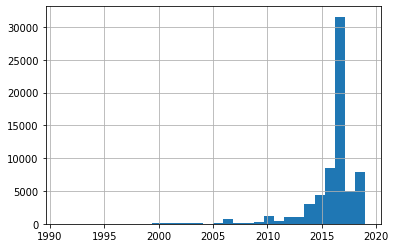

In [5]:
# Visualize distribution of age of observations
combined_normalized_csv.loc[(combined_normalized_csv['TIME_PERIOD']>1990) & (combined_normalized_csv['TIME_PERIOD']<2020), 'TIME_PERIOD'].hist(bins = 30)

# save fgure
plt.savefig(validation_and_analysis / 'observation_year_all_observations.png')

# Print number of observations older than 2010
old_data = combined_normalized_csv[combined_normalized_csv['TIME_PERIOD']<2010] 
# Number of observations older than 2010
old_data_grouped = old_data.groupby('INDICATOR_NAME').count()

print(f"The number  of observations older than 10 years is (NB: this is concerning all dimension subgroups): \n \n  {old_data_grouped.COUNTRY_ISO_3} \n ")

# # # # Calculate the % of obs older 2010 for each indicator
# Retrieve total number of observations
combined_normalized_csv_grouped = combined_normalized_csv.groupby('INDICATOR_NAME').count()

# Compare the number of rows older 2010 and total number of rows per indicators
old_data_analysis = old_data_grouped[['COUNTRY_ISO_3']].merge(
    right = combined_normalized_csv_grouped[['COUNTRY_ISO_3']],
    on = 'INDICATOR_NAME'
)

# Add column indicating % of obs older
old_data_analysis['OBS_PERCENT_OLDER_2010'] = round((old_data_analysis["COUNTRY_ISO_3_x"] / old_data_analysis["COUNTRY_ISO_3_y"]) * 100, 1) 

print(f"The percentage of observations older than 10 years is: \n \n  {old_data_analysis.OBS_PERCENT_OLDER_2010} \n ")

#### Subset dataset

This is the summary statistics about the age of observation of all _relevant_ rows. This means that:

* we are disregarding dimension-subgroups which were not used for normalization
* we disregard countries for which data was N/A for a given indicator (because these countries have TIME_PERIOD == 2020)

In other words, we are looking at each indicator at the subset of 195 countries for which data was available in the relevant dimension-subgroup.

The number  of observations older than 10 years is (NB: this is concerning only the relevant dimension-subgroup of the indicator): 
 
  Series([], Name: COUNTRY_ISO_3, dtype: int64) 
 
The percentage of observations older than 10 years is: 
 
  Series([], Name: OBS_PERCENT_OLDER_2010, dtype: float64) 
 


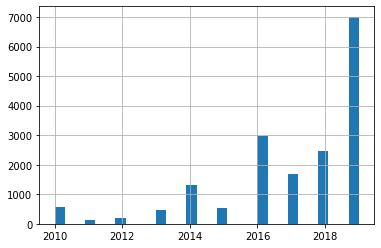

In [6]:
# Create a subset of the data we are actually interested in, i.e. 195 countries for each indicator --> filter out irrelevant dimension-subgroups
relevant_combined_normalized_csv = combined_normalized_csv.loc[
    combined_normalized_csv.SCALED_OBS_VALUE.notna()
]

# Visualize distribution of age of observations
relevant_combined_normalized_csv.loc[(relevant_combined_normalized_csv['TIME_PERIOD']>1990) & (relevant_combined_normalized_csv['TIME_PERIOD']<2020), 'TIME_PERIOD'].hist(bins = 30)
    
# save fgure
plt.savefig(validation_and_analysis / 'observation_year_relevant_dimension_subgroup.png')

# Print number of observations older than 2010
relevant_old_data = relevant_combined_normalized_csv[relevant_combined_normalized_csv['TIME_PERIOD']<2010] 

# Number of observations older than 2010
relevant_old_data_grouped = relevant_old_data.groupby('INDICATOR_NAME').count()

print(f"The number  of observations older than 10 years is (NB: this is concerning only the relevant dimension-subgroup of the indicator): \n \n  {relevant_old_data_grouped.COUNTRY_ISO_3} \n ")

# # # # Calculate the % of obs older 2010 for each indicator
# Retrieve total number of observations
relevant_combined_normalized_csv_grouped = relevant_combined_normalized_csv.groupby('INDICATOR_NAME').count()

# Compare the number of rows older 2010 and total number of rows per indicators
relevant_old_data_analysis = relevant_old_data_grouped[['COUNTRY_ISO_3']].merge(
    right = relevant_combined_normalized_csv_grouped[['COUNTRY_ISO_3']],
    on = 'INDICATOR_NAME'
)

# Add column indicating % of obs older
relevant_old_data_analysis['OBS_PERCENT_OLDER_2010'] = round((relevant_old_data_analysis["COUNTRY_ISO_3_x"] / relevant_old_data_analysis["COUNTRY_ISO_3_y"]) * 100, 1) 

print(f"The percentage of observations older than 10 years is: \n \n  {relevant_old_data_analysis.OBS_PERCENT_OLDER_2010} \n ")

# Save dataframe
relevant_old_data_analysis.to_csv(validation_and_analysis / 'percentage_observations_older_2010_per_indicator.csv',
    sep = ';')

### Number of NaN-countries per indicator

In [7]:
# # # # # # Calculate number of countries with NaN per indicator
relevant_observations = combined_normalized_csv.loc[
    (combined_normalized_csv.OBS_STATUS == 'O') |
    (combined_normalized_csv.SCALED_OBS_VALUE.notna()), 
]

# Calculate the total number of observations per indicator
total_obs_per_ind = relevant_observations.groupby('INDICATOR_CODE', as_index = False).count()[['INDICATOR_CODE','Unnamed: 0']]

# Calculate the number of NA observations
na_obs_per_ind = relevant_observations.loc[relevant_observations.OBS_STATUS == 'O', ].groupby('INDICATOR_CODE', as_index = False).count()[['INDICATOR_CODE','Unnamed: 0']]
 
joined = total_obs_per_ind.merge(
    right=na_obs_per_ind,
    on='INDICATOR_CODE',
    how='outer'
)

# Calculate percentage
joined['PERCENTAGE_OF_COUNTRIES_MISSING'] = joined['Unnamed: 0_y'] / joined['Unnamed: 0_x'] * 100

# Replace np.nan with 0
joined.loc[joined['PERCENTAGE_OF_COUNTRIES_MISSING'].isna() , 'PERCENTAGE_OF_COUNTRIES_MISSING'] = 0

# Get indincator name and source
joined = joined.merge(
    right=relevant_observations.groupby(
        'INDICATOR_CODE', as_index=False).first(
        )[['INDICATOR_CODE', 'INDICATOR_NAME', 'INTERNAL_SOURCE_ID']],
    on='INDICATOR_CODE',
    how='left'
)

# Drop irrelevant columns
joined = joined.drop(
    [
        'Unnamed: 0_x',
        'Unnamed: 0_y'
    ],
    axis=1
)

# Save as csv
joined.to_csv(
    validation_and_analysis / 'number_of_na_countries_per_indicator.csv',
    sep = ';'
) 



# For development and debugging: Calculate the total number of NA-countries per indicator
total_iso_3_per_ind = relevant_observations.groupby('INDICATOR_CODE', as_index = False).count()[['INDICATOR_CODE','COUNTRY_ISO_3']]

# Save as 
total_iso_3_per_ind.to_csv(
    validation_and_analysis / 'total_number_of_na_iso_3_codes_per_indicator.csv',
    sep = ';'
) 

### Number of indicators per... 

* Country
* Index
* Category
* Issue

In [8]:
# # # # # # Calculate number of indicators per country
indicator_per_country = combined_normalized_csv.loc[combined_normalized_csv.SCALED_OBS_VALUE.notna(), ].groupby('COUNTRY_ISO_3', as_index = False).count().sort_values('INDICATOR_CODE').merge(right=country_crba_list, on='COUNTRY_ISO_3').loc[:, ['COUNTRY_ISO_3', 'COUNTRY_NAME_y', 'INDICATOR_CODE']]

indicator_per_country.to_csv(validation_and_analysis /'indicators_per_country.csv', sep = ';')
print(f"The number of indicators per country: \n \n {indicator_per_country}")

# # # # # # Calculate the number of indicators per index/ category/ issue
grouping_list = [
    'INDICATOR_INDEX',
    'INDICATOR_ISSUE',
    'INDICATOR_CATEGORY'
]

for group in grouping_list:
    # Create target dataframe
    ndicator_per_x = combined_normalized_csv.groupby([group, 'INDICATOR_CODE'], as_index = False).first().groupby(group).count().INDICATOR_CODE

    # 
    ndicator_per_x.to_csv(validation_and_analysis / ('indicators_per_' + group + '.csv'), sep = ';')
    
    # Print result
    print(f"The number of indicators per {group}: \n \n {ndicator_per_x}")

The number of indicators per country: 
 
     COUNTRY_ISO_3      COUNTRY_NAME_y  INDICATOR_CODE
0             XKX              Kosovo              52
1             PSE  State of Palestine             100
2             LIE       Liechtenstein             101
3             MCO              Monaco             105
4             NRU               Nauru             112
..            ...                 ...             ...
190           COL            Colombia             183
191           MEX              Mexico             183
192           GHA               Ghana             183
193           IDN           Indonesia             184
194           PER                Peru             186

[195 rows x 3 columns]
The number of indicators per INDICATOR_INDEX: 
 
 INDICATOR_INDEX
Community and Environment    70
Marketplace                  52
Workplace                    73
Name: INDICATOR_CODE, dtype: int64
The number of indicators per INDICATOR_ISSUE: 
 
 INDICATOR_ISSUE
Child labour           

### Sanity checks
#### Value range check: always 0 < value < 10


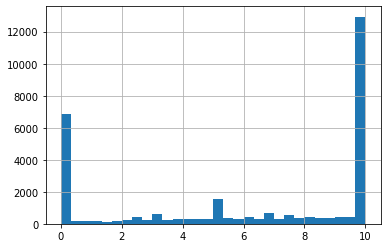

In [9]:
# Visualize distribution of scores across all indicators and countries
combined_normalized_csv.loc[:, 'SCALED_OBS_VALUE'].hist(bins = 30)

# save fgure
plt.savefig(validation_and_analysis / 'distribution_all_scores.png')

# Visualize the distirbution of scores of a specific countries
#combined_normalized_csv.loc[combined_normalized_csv.COUNTRY_ISO_3 == 'DEU', 'SCALED_OBS_VALUE'].hist(bins = 30)

#### Country-pair comparison sanity check

We expect the score of some countries to be higher for most indiators than that of other countries. With the following country pairs we tried to have a global coverage with countries from each world region: 

* Germany > Indonesia
* Panama > Peru 
* UK > India 
* Canada > Tanzania
* Sweden > Mexico
* Netherlands > Myanmar

In [10]:
country_pair_list = [
    ['DEU', 'IDN'],
    ['PAN', 'PER'],
    ['GBR', 'IND'],
    ['CAN', 'TZA'],
    ['SWE', 'MEX'],
    ['NLD', 'MMR'],
    ['USA', 'CHN']
]

for pair in country_pair_list:
    # Subset total dataframe
    df = combined_normalized_csv.loc[
        (combined_normalized_csv['COUNTRY_ISO_3'] == pair[0]) |
        (combined_normalized_csv['COUNTRY_ISO_3'] == pair[1]),
        ['COUNTRY_ISO_3', 'SCALED_OBS_VALUE', 'INDICATOR_CODE', 'INTERNAL_SOURCE_ID']
    ]

    # Check there aren't duplicates
    # TO DO re-write this into an asser statement
    df = df.loc[df.SCALED_OBS_VALUE.notna(), :].drop_duplicates(subset = ['COUNTRY_ISO_3', 'INDICATOR_CODE'])

    # Pivot the table (long to wide format)
    df = df.pivot(index = ['INDICATOR_CODE', 'INTERNAL_SOURCE_ID'], columns = 'COUNTRY_ISO_3', values = 'SCALED_OBS_VALUE')

    # Create new column
    df.loc[
        df[pair[0]] < df[pair[1]],
        'INDICATOR_REQUIRES_DOUBLE_CHECK'
    ] = 'YES'

    # safe dataframe
    df.to_csv(validation_and_analysis / ('country_pair_score_comparison_sanity_check_' + pair[0] + '-' + pair[1] + '.csv'), sep = ";") 

#### Aggregated scores, country ranking and share of outcome indicators 

We expect certain countries to be in certain segments of the overall ranking. That is, we generally expect the distribution of rankings from best to worst to be as follow for most indicators: 

* Scandinavian countries
* Other European countries (northern) + Canada
* USA + Southern European countries
* Emerging economies (Brasil, Turke, Ethiopia, Asian emerging economies)
* Countries in conflict

The following code calculates the aggregated score, ranking and share of outcome indicators in the aggregated score :

* overall
* issue
* category
* index

to examine these assumption.  

##### Overall scores

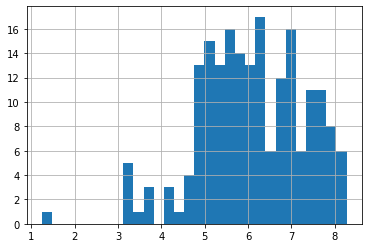

In [11]:
# # # # # # # 
# Overall score
overall_score = combined_normalized_csv.loc[:, ['COUNTRY_ISO_3', 'SCALED_OBS_VALUE', 'COUNTRY_NAME']].groupby(by = ['COUNTRY_ISO_3']).mean()

# Get back country_name (could not be include in group by)
overall_score = overall_score.merge(
    right=country_crba_list[['COUNTRY_ISO_3', 'COUNTRY_NAME']],
    on='COUNTRY_ISO_3',
    how='left'
)

# Rename column 
overall_score = overall_score.rename(columns={'SCALED_OBS_VALUE' : 'OVERALL_SCORE'})

# Visualize distribution of overall scores
overall_score.loc[:, 'OVERALL_SCORE'].hist(bins = 30)

# save fgure
plt.savefig(validation_and_analysis / 'distribution_overall_country_scores.png')

Calculate the percentage of outcome indicators in the overall score and append it to the overall score dataframe.

In [12]:
# # # # # 
# Calculate the share of outcome indicators per country in the overall score
# # # # #
# Total number of indicators per country
total_number_of_indicators = combined_normalized_csv.loc[
    combined_normalized_csv.SCALED_OBS_VALUE.notna(),
].groupby(
    'COUNTRY_ISO_3',
    as_index = False
).count().sort_values(
    'INDICATOR_CODE'
).merge(
    right=country_crba_list,
    on='COUNTRY_ISO_3'
).loc[
    :,
    [
        'COUNTRY_ISO_3',
        'COUNTRY_NAME_y',
        'INDICATOR_CODE'
    ]
].rename(
    columns = {
        'INDICATOR_CODE' : 'TOTAL_NUMBER_OF_INDICATORS_IN_TOTAL'
    }
)

# Outcome indicators per country
total_number_of_outcome_indicators = combined_normalized_csv.loc[
    combined_normalized_csv.SCALED_OBS_VALUE.notna() & (combined_normalized_csv.INDICATOR_CATEGORY == 'Outcome'),
].groupby(
    'COUNTRY_ISO_3',
    as_index = False
).count().sort_values(
    'INDICATOR_CODE'
).merge(
    right=country_crba_list,
    on='COUNTRY_ISO_3'
).loc[
    :,
    [
        'COUNTRY_ISO_3',
        'COUNTRY_NAME_y',
        'INDICATOR_CODE'
    ]
].rename(
    columns = {
        'INDICATOR_CODE' : 'OUTCOME_INDICATORS_IN_TOTAL'
    }
)

# Merge the two dataframes
temp = total_number_of_indicators.merge(
    right=total_number_of_outcome_indicators,
    on = [
        'COUNTRY_ISO_3',
        'COUNTRY_NAME_y'
    ]
)

# Calculate percentage
temp[
    'OUTCOME_INDICATORS_SHARE_INDEX'
] = round(temp['OUTCOME_INDICATORS_IN_TOTAL'] / temp['TOTAL_NUMBER_OF_INDICATORS_IN_TOTAL'] * 100, 2)

# Join to the overall score sheet
overall_score = overall_score.merge(
    right = temp,
    on=[
        'COUNTRY_ISO_3'
    ]
)

In [13]:
# Save dataframe
overall_score.to_csv(    
    path_or_buf = validation_and_analysis / 'overall_score_country_ranking.csv',
    sep = ";")

##### Scores per issue/ index/ category

Compute the aggregated score per issue/ index/ category

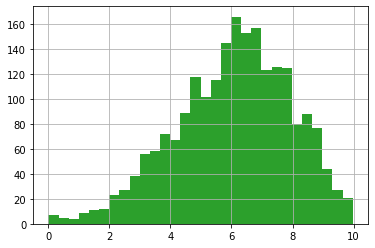

In [14]:
###############
# Loop through ranking per issue/ category/ index
dimension_list = [
    'INDICATOR_INDEX',
    'INDICATOR_CATEGORY',
    'INDICATOR_ISSUE'
]

for element in dimension_list:
    # Subset to relevant dimension
    dataframe_score = combined_normalized_csv.loc[:, [element,'COUNTRY_ISO_3', 'SCALED_OBS_VALUE']].groupby(by = [element,'COUNTRY_ISO_3'], as_index= False).mean()

    # Get back country_name (could not be include in group by)
    dataframe_score = dataframe_score.merge(
        right=country_crba_list[['COUNTRY_ISO_3', 'COUNTRY_NAME']],
        on='COUNTRY_ISO_3',
        how='left'
    )

    # Rename column 
    dataframe_score = dataframe_score.rename(columns={'SCALED_OBS_VALUE' : (element + '_SCORE')})

    # Save dataframe
    dataframe_score.to_csv(    
        path_or_buf = validation_and_analysis / (element + '_score_country_ranking.csv'),
        sep = ";")

    # Visualize distribution of overall scores
    dataframe_score.loc[:, (element + '_SCORE')].hist(bins = 30)

    # save fgure
    plt.savefig(validation_and_analysis / ('distribution_' + element + '_country_scores.png'))

To the aggregated score sheet, add the share of outcome indicators (since they are most relevant).

In [15]:
# Create list to loop through
aggregated_score_spec_list = [
    [
        'INDICATOR_ISSUE',
        'TOTAL_NUMBER_OF_INDICATORS_IN_ISSUE',
        'TOTAL_NUMBER_OF_OUTCOME_INDICATORS_IN_ISSUE'
    ],
    [
        'INDICATOR_INDEX',
        'TOTAL_NUMBER_OF_INDICATORS_IN_INDEX',
        'TOTAL_NUMBER_OF_OUTCOME_INDICATORS_IN_INDEX'
    ]
]

# Loop through index and issue
for element in aggregated_score_spec_list:
    # Read dataframe
    dataframe = pd.read_csv(
        validation_and_analysis / (element[0]+'_score_country_ranking.csv'),
        sep = ';'
    )

    # Total number of indicators per country
    total_number = combined_normalized_csv.loc[
        combined_normalized_csv.SCALED_OBS_VALUE.notna(),
    ].groupby(
        [
            'COUNTRY_ISO_3',
            element[0]
        ],
        as_index = False
    ).count().sort_values(
        'INDICATOR_CODE'
    ).merge(
        right=country_crba_list,
        on='COUNTRY_ISO_3'
    ).loc[
        :,
        [
            'COUNTRY_ISO_3',
            'COUNTRY_NAME_y',
            'INDICATOR_CODE',
            element[0]
        ]
    ].rename(
        columns = {
            'INDICATOR_CODE' : element[1]
        }
    )


    # Outcome indicators per country
    outcome_number = combined_normalized_csv.loc[
        (combined_normalized_csv.SCALED_OBS_VALUE.notna()) & (combined_normalized_csv.INDICATOR_CATEGORY == 'Outcome'),
    ].groupby(
        [
            'COUNTRY_ISO_3',
            element[0]
        ],
        as_index = False
    ).count().sort_values(
        'INDICATOR_CODE'
    ).merge(
        right=country_crba_list,
        on='COUNTRY_ISO_3'
    ).loc[
        :,
        [
            'COUNTRY_ISO_3',
            'COUNTRY_NAME_y',
            'INDICATOR_CODE',
            element[0]
        ]
    ].rename(
        columns = {
            'INDICATOR_CODE' : element[2]
        }
    ) 

    # Merge the two dataframes
    temp = total_number.merge(
        right=outcome_number,
        on = [
            'COUNTRY_ISO_3',
            'COUNTRY_NAME_y',
            element[0]
        ]
    )

    # Calculate percentage
    temp[
        (element[0] + 'OUTCOME_INDICATORS_SHARE')
    ] = round(temp[element[2]] / temp[element[1]] * 100, 2) 

    # Join to the overall score sheet
    dataframe = dataframe.merge(
        right = temp,
        on=[
            'COUNTRY_ISO_3',
            element[0]
        ]
    )

    # Save dataframe
    dataframe.to_csv(
        validation_and_analysis / (element[0]+'_score_country_ranking.csv'),
        sep = ';'
    )

In [16]:
# # # # # # #  TO DO INCLUDE THIS IN THE OVERALL SCORE SHEET OF ISSUE SCORES
# Total number of indicators per country
total_number_of_indicators_per_issue = combined_normalized_csv.loc[
    combined_normalized_csv.SCALED_OBS_VALUE.notna(),
].groupby(
    [
        'COUNTRY_ISO_3',
        'INDICATOR_ISSUE' # HERE
    ],
    as_index = False
).count().sort_values(
    'INDICATOR_CODE'
).merge(
    right=country_crba_list,
    on='COUNTRY_ISO_3'
).loc[
    :,
    [
        'COUNTRY_ISO_3',
        'COUNTRY_NAME_y',
        'INDICATOR_CODE',
        'INDICATOR_ISSUE' # HERE
    ]
].rename(
    columns = {
        'INDICATOR_CODE' : 'TOTAL_NUMBER_OF_INDICATORS_IN_ISSUE' # HERE
    }
)

# Outcome indicators per country
total_number_of_outcome_indicators_per_issue = combined_normalized_csv.loc[
    (combined_normalized_csv.SCALED_OBS_VALUE.notna()) & (combined_normalized_csv.INDICATOR_CATEGORY == 'Outcome'),
].groupby(
    [
        'COUNTRY_ISO_3',
        'INDICATOR_ISSUE' # HERE
    ],
    as_index = False
).count().sort_values(
    'INDICATOR_CODE'
).merge(
    right=country_crba_list,
    on='COUNTRY_ISO_3'
).loc[
    :,
    [
        'COUNTRY_ISO_3',
        'COUNTRY_NAME_y',
        'INDICATOR_CODE',
        'INDICATOR_ISSUE' # HERE
    ]
].rename(
    columns = {
        'INDICATOR_CODE' : 'TOTAL_NUMBER_OF_OUTCOME_INDICATORS_IN_ISSUE' # HERE
    }
) 

total_number_of_outcome_indicators_per_issue

# Merge the two dataframes
temp = total_number_of_indicators_per_issue.merge(
    right=total_number_of_outcome_indicators_per_issue,
    on = [
        'COUNTRY_ISO_3',
        'COUNTRY_NAME_y',
        'INDICATOR_ISSUE' # HERE
    ]
)

# Calculate percentage
temp[
    'OUTCOME_INDICATORS_SHARE_INDEX'
] = round(temp['TOTAL_NUMBER_OF_INDICATORS_IN_ISSUE'] / temp['TOTAL_NUMBER_OF_OUTCOME_INDICATORS_IN_ISSUE'] * 100, 2) # HERE

### Comparison of 2018 and 2020 scores

* Compare th rank of countries in 2018and 2020


In [17]:
# Creat empty dataframe
crba_2018_scores = pd.DataFrame()

# Crete list to loop through all indeces
index_parameter_list = [#workplace
    [
        'CRWP_Score_Sheet_V31.xlsx',
        'Unnamed: 152',
        'Workplace'
    ], # Marketlace
    [
        'CRMP_Score_Sheet_V23.xlsx',
        'Unnamed: 100',
        'Marketplace' 
    ],
    [
        'CRCE_Score_Sheet_V25.xlsx',
        'Unnamed: 133',
        'Community and Environment'
    ]
]

# Loop through list
for index in index_parameter_list:
    # read file
    df = pd.read_excel(
        cwd / 'data_out'  / 'Nov 2018 - Full global release' / index[0],
        sheet_name = 'Analysis sheet'
    )

    # Discard unnecessary column
    df = df.loc[:, ['Analysis part', index[1]]]

    # Add country_iso_3 code
    df = df.merge(
        right = country_full_list[['COUNTRY_ISO_3', 'COUNTRY_NAME']],
        left_on='Analysis part',
        right_on='COUNTRY_NAME',
        how='inner'
    )

    # Add indicator index column
    df['INDICATOR_INDEX'] = index[2]

    # Rename target column
    df = df.rename(
        columns = {
            index[1] : 'CRBA_2018_INDEX_SCORE'
        }
    )

    # Append to dataframe
    crba_2018_scores = crba_2018_scores.append(
        df
    )

count    576.000000
mean       0.502649
std        1.133213
min       -5.214206
25%       -0.075737
50%        0.556464
75%        1.177651
max        5.447047
Name: SCORE_CHANGE, dtype: float64


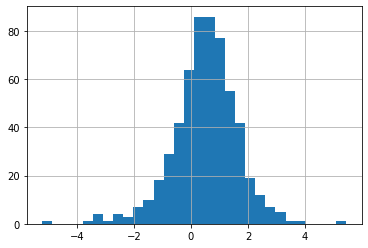

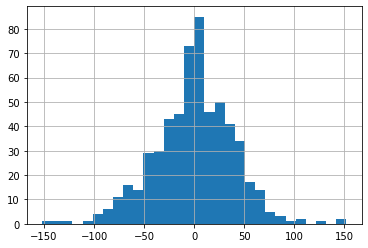

In [18]:
# Merge 2018 and 2019 data
crba_2020_scores = pd.read_csv(
    validation_and_analysis / 'INDICATOR_INDEX_score_country_ranking.csv',
    sep = ';'
)

# Join dataframe
index_scores_2018_2020 = crba_2020_scores.merge(
    right = crba_2018_scores [['INDICATOR_INDEX', 'COUNTRY_ISO_3', 'CRBA_2018_INDEX_SCORE']],
    on = ['INDICATOR_INDEX', 'COUNTRY_ISO_3']
)

# Calculate difference between scores
index_scores_2018_2020['SCORE_CHANGE'] = index_scores_2018_2020['INDICATOR_INDEX_SCORE'] - index_scores_2018_2020['CRBA_2018_INDEX_SCORE']

print(index_scores_2018_2020['SCORE_CHANGE'].astype(float).describe())

# cast as numeric to create rank
index_scores_2018_2020['CRBA_2018_INDEX_SCORE'] = index_scores_2018_2020['CRBA_2018_INDEX_SCORE'].astype(float)

index_scores_2018_2020['INDICATOR_INDEX_SCORE'] = index_scores_2018_2020['INDICATOR_INDEX_SCORE'].astype(float)


# Add rank 2018
index_scores_2018_2020['RANK_2018'] = index_scores_2018_2020.loc[:, ['INDICATOR_INDEX', 'CRBA_2018_INDEX_SCORE']].groupby(['INDICATOR_INDEX'], as_index=True).rank(axis=0, method='dense', ascending=False)

# Add rank 2020
index_scores_2018_2020['RANK_2020'] = index_scores_2018_2020.loc[:, ['INDICATOR_INDEX', 'INDICATOR_INDEX_SCORE']].groupby(['INDICATOR_INDEX'], as_index=True).rank(axis=0, method='dense', ascending=False)

# Calculate change of rank from 2018 to 2020
index_scores_2018_2020['RANK_CHANGE'] = index_scores_2018_2020['RANK_2018'] - index_scores_2018_2020['RANK_2020']

# Save dataframe
index_scores_2018_2020.to_csv(
    validation_and_analysis / 'index_scores_comparison_2018_2020.csv',
    sep=';'
)

# Visualize the distributon of score changes
index_scores_2018_2020.loc[:, 'SCORE_CHANGE'].hist(bins = 30)

# save fgure
plt.savefig(validation_and_analysis / 'index_score_change_distriution')
plt.show()


# Visualize the distributon of rank changes
index_scores_2018_2020.loc[:, 'RANK_CHANGE'].hist(bins = 30)

# save fgure
plt.savefig(validation_and_analysis / 'index_rank_change_distriution')